# Connect to Personal Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Necessary Package

In [41]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-2e8ju_yw
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-2e8ju_yw


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks,losses,optimizers
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import io
import glob,os


# Prepare the dataset

In [116]:
train_images=[]
train_masks=[]
root_path="/content/drive/MyDrive/data-science-bowl-2018-2/train"

#Import train images and mask 
train_images_dir=os.path.join(root_path,'inputs')
for image_file in sorted(os.listdir(train_images_dir)):
  train_image=cv2.imread(os.path.join(train_images_dir,image_file),cv2.COLOR_BGR2RGB)
  train_image=cv2.resize(train_image,(128,128))
  train_images.append(train_image)

train_masks_dir=os.path.join(root_path,'masks')
for mask_file in sorted(os.listdir(train_masks_dir)):
  train_mask=cv2.imread(os.path.join(train_masks_dir,mask_file),cv2.IMREAD_GRAYSCALE)
  train_mask=cv2.resize(train_mask,(128,128))
  train_masks.append(train_mask)



#Import test images and mask
test_images=[]
test_masks=[]
root_path="/content/drive/MyDrive/data-science-bowl-2018-2/test"

test_images_dir=os.path.join(root_path,"inputs")
for image_file in sorted(os.listdir(test_images_dir)):
  test_image=cv2.imread(os.path.join(test_images_dir,image_file),cv2.COLOR_BGR2RGB)
  #test_image=cv2.cvtColor(test_image,,cv2.COLOR_BGR2RGB)
  test_image=cv2.resize(test_image,(128,128))
  test_images.append(test_image)

test_masks_dir=os.path.join(root_path,"masks")
for mask_file in sorted(os.listdir(test_masks_dir)):
  test_mask=cv2.imread(os.path.join(test_masks_dir,mask_file),cv2.IMREAD_GRAYSCALE)
  test_mask=cv2.resize(test_mask,(128,128))
  test_masks.append(test_mask)





In [117]:
#Change to list images to numpy array
train_images_np=np.array(train_images)
train_masks_np=np.array(train_masks)
test_images_np=np.array(test_images)
test_masks_np=np.array(test_masks)

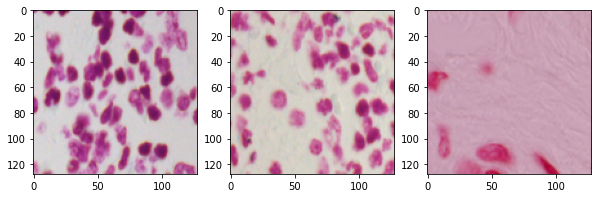

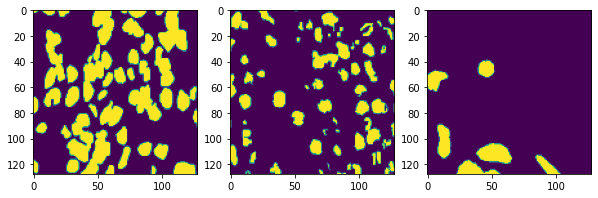

In [118]:
#Show a couple of train image and mask examples
plt.figure(figsize=(10,10))
for i in range(1,4):
  plt.subplot(1,3,i)
  plt.imshow(train_images[i])
plt.show()

plt.figure(figsize=(10,10))
for i in range(1,4):
  plt.subplot(1,3,i)
  plt.imshow(train_masks[i])

plt.show()



In [119]:
#Expand the mask dimension by adding one more channel 
train_masks_np_exp=np.expand_dims(train_masks_np,axis=-1)
test_masks_np_exp=np.expand_dims(test_masks_np,axis=-1)
#Check the uniquess of the mask output
print(np.unique(train_masks[0]))

[  0  64 128 191 255]


In [120]:
#Change the value of label value of mask in to 0 or 1
converted_train_masks=np.round(train_masks_np_exp/255.0).astype(np.int64)
converted_test_masks=np.round(test_masks_np_exp/255.0).astype(np.int64)
print(np.unique(converted_test_masks[0]))

[0 1]


In [121]:
#Normalize the train and test images
converted_train_images=train_images_np/255.0
converted_test_images=test_images_np/255.0

In [122]:
#Convert the numpy array to tensor
x_train_tensor=tf.data.Dataset.from_tensor_slices(converted_train_images)
x_test_tensor=tf.data.Dataset.from_tensor_slices(converted_test_images)
y_train_tensor=tf.data.Dataset.from_tensor_slices(converted_train_masks)
y_test_tensor=tf.data.Dataset.from_tensor_slices(converted_test_masks)



In [123]:
#Combine the images and masks using zip
train_dataset=tf.data.Dataset.zip((x_train_tensor,y_train_tensor))
test_dataset=tf.data.Dataset.zip((x_test_tensor,y_test_tensor))

# Configure the model

In [124]:
#Create a subclass layer for data augmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self,seed=3344):
    super().__init__()
    self.augment_inputs=layers.RandomFlip(mode="horizontal",seed=seed)
    self.augment_labels=layers.RandomFlip(mode="horizontal",seed=seed)
  
  def call(self,inputs,labels):
    inputs=self.augment_inputs(inputs)
    labels=self.augment_labels(labels)
    return inputs,labels


In [125]:
#Convert into prefetch dataset
#Define the steps per epoch
TRAIN_LENGTH=len(train_dataset)
AUTOTUNE=tf.data.AUTOTUNE
BATCH_SIZE=8
BUFFER_SIZE=1000
STEPS_PER_EPOCH=TRAIN_LENGTH//BATCH_SIZE

In [126]:
#Configure Input pipeline
train_batches=(
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)

)

test_batches=test_dataset.batch(BATCH_SIZE)

In [127]:
#Create subfunction to display image, mask and prediction
def display(display_list):
  plt.figure(figsize=(15,15))
  title=['Input Image','True Mask','Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


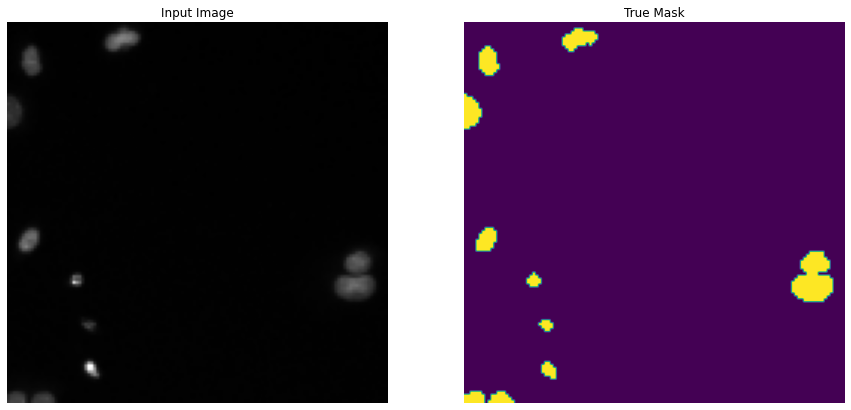

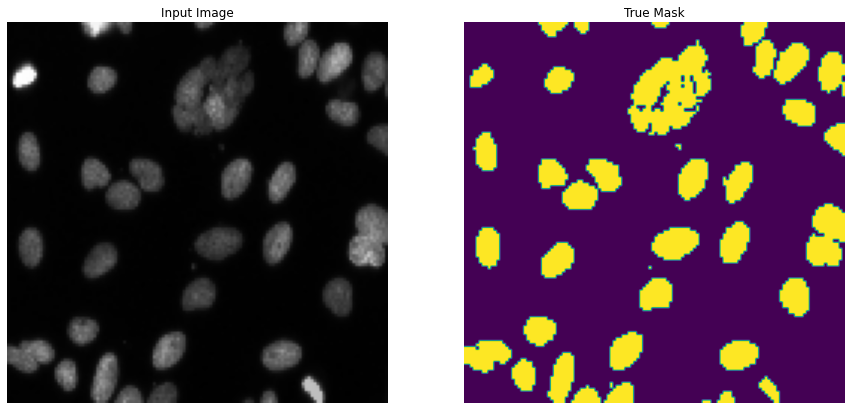

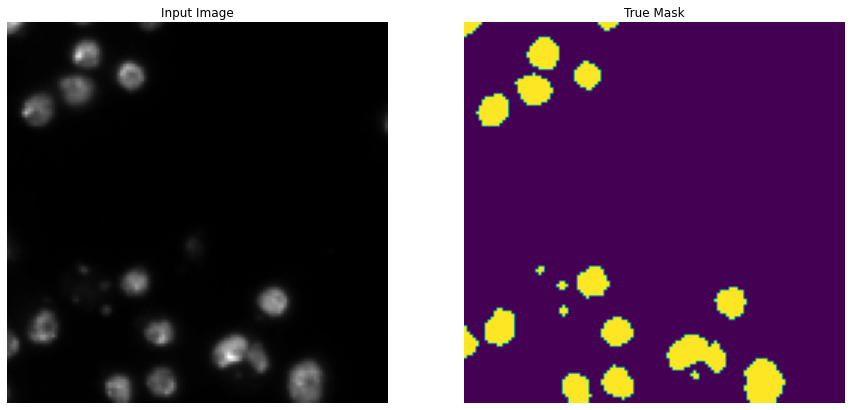

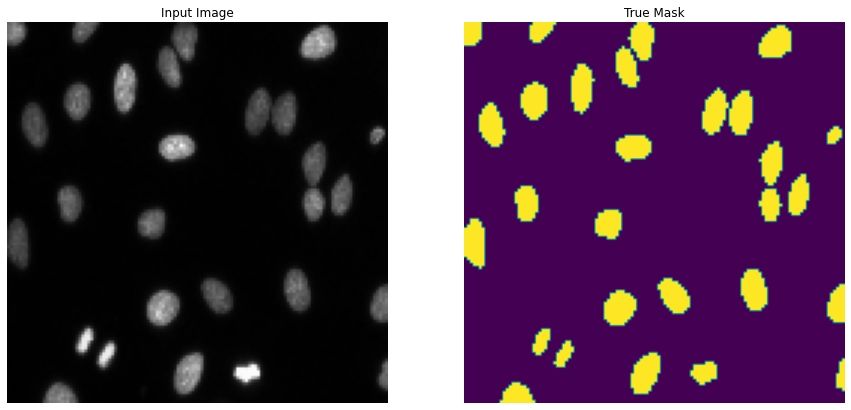

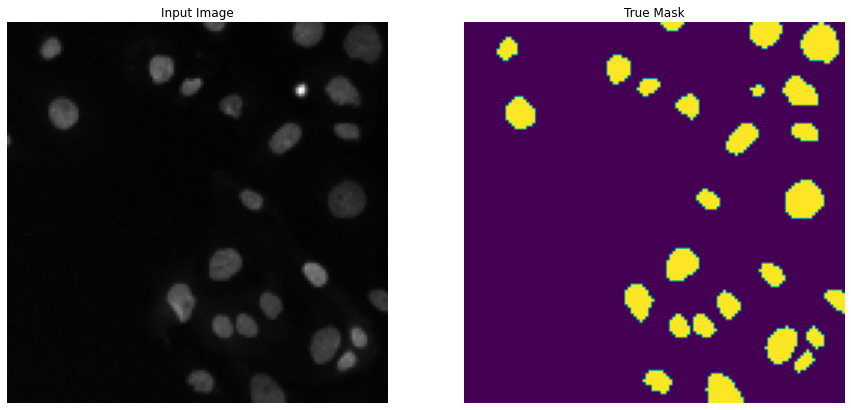

In [128]:
#Display a couple of image and mask of train
for images,masks in train_batches.take(5):
  sample_image,sample_mask=images[0],masks[0]
  display([sample_image,sample_mask])

In [129]:
#Create the encoder of U-net where pretrained MobileNetV2 implemented
base_model=tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)
#Print the layer of the model
base_model.summary()


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [130]:
#Use the activation of these layers in MobileNet V2 as feature extraction model
layer_name=[
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

#Extract these layers and assign into base_model_outputs
base_model_outputs=[base_model.get_layer(name).output for name in layer_name]

#Create the feature extraction model
down_stack=tf.keras.Model(inputs=base_model.input,outputs=base_model_outputs)
#Freeze the layers of feature extraction model
down_stack.trainable=False
down_stack.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [131]:
# To creating the upsampling layer
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [132]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [133]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [134]:
tf.keras.utils.plot_model(model, show_shapes=True)

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

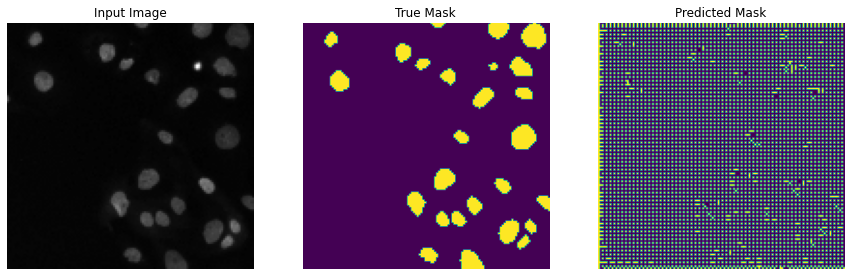

In [135]:
show_predictions()

In [136]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Train Model

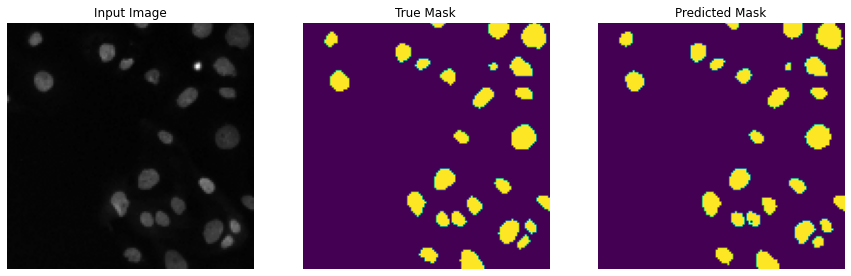


Sample Prediction after epoch 10

75/75 [==============================] - 4s 49ms/step - loss: 0.0770 - accuracy: 0.9690 - val_loss: 0.0766 - val_accuracy: 0.9685


In [137]:
#Train the U-Net model
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_dataset)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

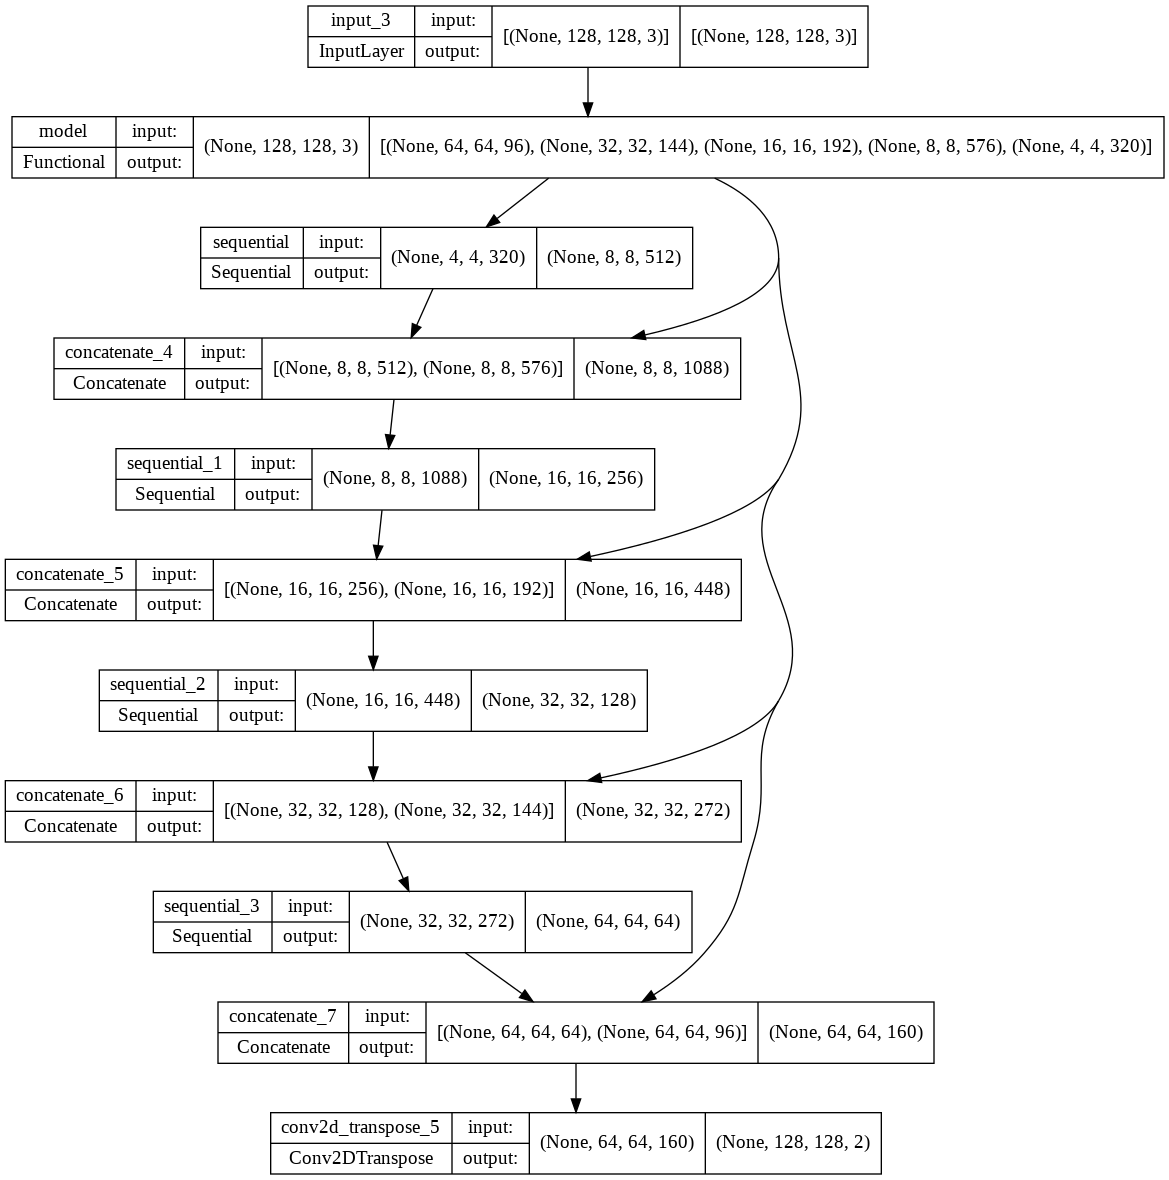

In [39]:
#Display the simplified version of architecture model.
keras.utils.plot_model(model, "model.png", show_shapes=True)

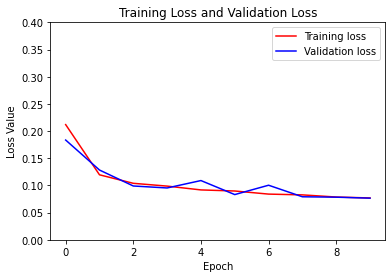

In [142]:
#Graph of Training and Validation Loss against Epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'r',color='b', label='Validation loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.4])
plt.legend()
plt.show()

# Result

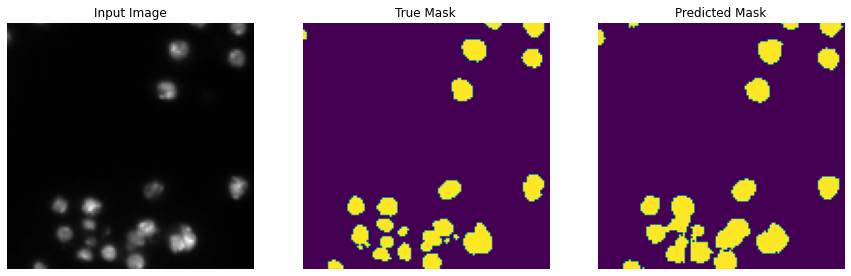

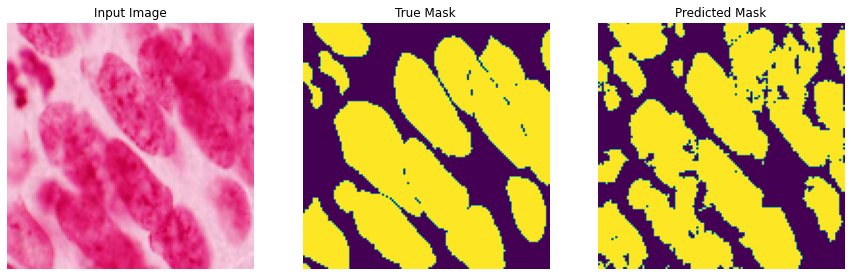

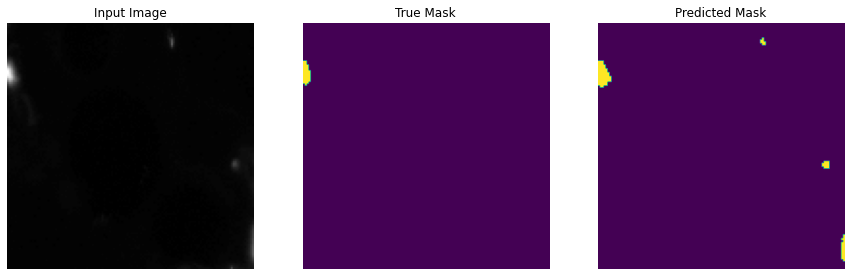

In [93]:
#Show the prediction using test image
show_predictions(test_batches, 3)